In [2]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.control import ConstControl
from pandapower.timeseries import DFData, OutputWriter, run_timeseries
from pandapower import ppException

import matplotlib.pyplot as plt
from scipy.stats import norm


In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

## Power Network 

In [4]:
# Load the Illinois200 buses system
net = pn.case_illinois200()

# View all generator (gen) information and Slack bus
gen_info = net.gen
print(gen_info)
print(net.ext_grid)

# Identify PV buses (buses with generators) in the IEEE 300-bus system
pv_buses = net.gen['bus'].tolist()

print("PV Buses in illinois200 system:", pv_buses)

    name  bus    p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0   None   48    4.53   1.04     NaN       -2.11        0.55      1.0  False   
1   None   49    4.53   1.04     NaN       -2.11        0.55      1.0  False   
2   None   50    4.53   1.04     NaN       -2.11        0.55      1.0  False   
3   None   51    4.53   1.04     NaN       -2.11        0.55      1.0  False   
4   None   52    9.07   1.04     NaN       -4.23        1.11      1.0  False   
5   None   64   60.66   1.04     NaN      -32.04       21.66      1.0  False   
6   None   66    4.70   1.04     NaN       -2.19        0.57      1.0  False   
7   None   67   27.92   1.04     NaN      -13.01        3.41      1.0  False   
8   None   68   27.92   1.04     NaN      -13.01        3.41      1.0  False   
9   None   69   27.92   1.04     NaN      -13.01        3.41      1.0  False   
10  None   70   27.92   1.04     NaN      -13.01        3.41      1.0  False   
11  None   71   27.92   1.04     NaN    

In [5]:
# View the bus information of the external power grid (Slack bus)
slack_bus_numbers = net.ext_grid['bus'].values
print("Slack bus numbers:", slack_bus_numbers)

# View load information
print(net.load)

# Calculate total active power and reactive power
total_p = net.load['p_mw'].sum()  # Total active power
total_q = net.load['q_mvar'].sum()  # Total reactive power

print(f"Total active power load of IEEE 300-bus system: {total_p} MW")
print(f"Total reactive power load of IEEE 300-bus system: {total_q} MVar")

Slack bus numbers: [188]
     name  bus    p_mw  q_mvar  const_z_percent  const_i_percent  sn_mva  \
0    None    1   10.95    3.12              0.0              0.0     NaN   
1    None    3    2.72    0.77              0.0              0.0     NaN   
2    None    5   12.50    3.56              0.0              0.0     NaN   
3    None    7   35.20   10.03              0.0              0.0     NaN   
4    None    9   63.29   18.04              0.0              0.0     NaN   
5    None   11    0.49    0.14              0.0              0.0     NaN   
6    None   12    4.04    1.15              0.0              0.0     NaN   
7    None   15   71.70   20.44              0.0              0.0     NaN   
8    None   17    1.14    0.33              0.0              0.0     NaN   
9    None   18    1.23    0.35              0.0              0.0     NaN   
10   None   19    1.81    0.52              0.0              0.0     NaN   
11   None   20    7.38    2.10              0.0              0.

In [7]:
# Initialize an empty list to store the installed capacities of each generator
installed_capacities = []

# Loop through each row in the gen_info DataFrame to extract information
for i, row in gen_info.iterrows():
    bus_id = row['bus']  # Get the bus ID for the generator
    installed_capacity = row['max_p_mw']  # Get the installed capacity of the generator in MW
    print(f"Generator at Bus {bus_id}: Installed Capacity = {installed_capacity} MW")
    installed_capacities.append(installed_capacity)  # Append the capacity to the list

# Calculate the total installed capacity of all generators
total_installed_capacity = sum(installed_capacities)
print(f"Total Installed Capacity = {total_installed_capacity} MW")

# Create Static Generators (sgen) for the PV buses
for bus, installed_capacity in zip(pv_buses, installed_capacities):
    pp.create_sgen(net, bus, p_mw=0, max_p_mw=installed_capacity, name=f"PV_bus_{bus}")
    
#Remove any extra sgen outside the PV buses.
for bus in net.sgen['bus'].values:
    if bus not in pv_buses:
        net.sgen.drop(net.sgen[net.sgen['bus'] == bus].index, inplace=True)

# View all sgen information
sgen_info = net.sgen
print(sgen_info)

Generator at Bus 48: Installed Capacity = 4.53 MW
Generator at Bus 49: Installed Capacity = 4.53 MW
Generator at Bus 50: Installed Capacity = 4.53 MW
Generator at Bus 51: Installed Capacity = 4.53 MW
Generator at Bus 52: Installed Capacity = 9.07 MW
Generator at Bus 64: Installed Capacity = 150.4 MW
Generator at Bus 66: Installed Capacity = 4.7 MW
Generator at Bus 67: Installed Capacity = 27.92 MW
Generator at Bus 68: Installed Capacity = 27.92 MW
Generator at Bus 69: Installed Capacity = 27.92 MW
Generator at Bus 70: Installed Capacity = 27.92 MW
Generator at Bus 71: Installed Capacity = 27.92 MW
Generator at Bus 72: Installed Capacity = 27.92 MW
Generator at Bus 75: Installed Capacity = 4.0 MW
Generator at Bus 76: Installed Capacity = 2.4 MW
Generator at Bus 89: Installed Capacity = 3.2 MW
Generator at Bus 90: Installed Capacity = 5.0 MW
Generator at Bus 93: Installed Capacity = 18.0 MW
Generator at Bus 103: Installed Capacity = 99.0 MW
Generator at Bus 104: Installed Capacity = 198.

## Load data and Data processing

In [8]:
# Load the CSV file with the ERCOT time-series data file
# file_path = 'C:\\Users\\default.DESKTOP-C4C7JDR\\Desktop\\ERCOT SOLAR DATA.xlsx'  # Home PC
file_path = 'C:\\Users\\jliu359\\OneDrive - Syracuse University\\Desktop\\ERCOT SOLAR DATA.xlsx' #Lab PC
ercot_data = pd.read_excel(file_path)
# Read data
print(ercot_data.head())

# Extract the time and PV generation columns
# Set the time column as the index and ensure it's in DateTime format
ercot_data['Time (Hour-Ending)'] = pd.to_datetime(ercot_data['Time (Hour-Ending)'])
ercot_data.set_index('Time (Hour-Ending)', inplace=True)
pv_generation = ercot_data['ERCOT.PVGR.GEN']

# Scale ERCOT's generation to match the total installed capacity of the PV buses
scaling_factor = total_installed_capacity / 14249  # 14249 MW is the total solar installed capacity in the ERCOT dataset
scaled_pv_generation = pv_generation * scaling_factor

# Prepare a DataFrame to hold profiles for each PV bus with an integer index
profiles_df = pd.DataFrame(index=range(len(ercot_data)))

   Time (Hour-Ending)       Date    ERCOT.LOAD  ERCOT.PVGR.GEN  \
0 2023-01-01 01:00:00 2023-01-01  35829.306163        0.449746   
1 2023-01-01 02:00:00 2023-01-01  35245.390234        0.454733   
2 2023-01-01 03:00:00 2023-01-01  34599.761810        0.443528   
3 2023-01-01 04:00:00 2023-01-01  34227.151061        0.458567   
4 2023-01-01 05:00:00 2023-01-01  34093.414143        0.451126   

   Total Solar Installed, MW  Solar Output, % of Load  \
0                      14249                 0.001255   
1                      14249                 0.001290   
2                      14249                 0.001282   
3                      14249                 0.001340   
4                      14249                 0.001323   

   Solar Output, % of Installed  Solar 1-hr MW change  Solar 1-hr % change  \
0                      0.003156                   NaN                  NaN   
1                      0.003191                   0.0                  0.0   
2                      0.0

In [9]:
# Assign the scaled generation to the PV buses as injected photovoltaic output based on their capacities
for i, bus in enumerate(pv_buses):
    # Calculate the proportion of generation for each PV bus
    bus_scaling_factor = installed_capacities[i] / total_installed_capacity
    bus_generation_profile = scaled_pv_generation * bus_scaling_factor

    # Add the generation profile to the DataFrame with a consistent column name
    column_name = f'bus_{bus}_p_mw'
    profiles_df[column_name] = bus_generation_profile.values

    # Create a DFData object with the profiles DataFrame
    data_source = DFData(profiles_df)

    # Create ConstControl objects for each PV bus to update active power over time
    for i, bus in enumerate(pv_buses):
        element_index = net.sgen[net.sgen['bus'] == bus].index[0]
        column_name = f'bus_{bus}_p_mw'
        ConstControl(net, element='sgen', variable='p_mw', element_index=element_index, data_source=data_source,
                     profile_name=column_name)


## Time-series Simulation
Runs the power flow simulation iteratively for each time step. After each step, it computes the power flow and stores the results.

In [10]:
# Set up the output writer for results
# output_dir = "D:/My workspace/300Buses"#Home PC
output_dir = "C:/Apps-SU/300Buses/" #Lab PC
ow = OutputWriter(net, output_path=output_dir, output_file_type=".xlsx")
# Define Record parameters
ow.log_variable('res_sgen','p_mw')

# Define time steps as a range matching the data length
time_steps = list(range(0, 8760))

# for bus in pv_buses:
#     pp.create_shunt(net, bus=bus, q_mvar=50, p_mw=0)  # Add a 50 MVar shunt capacitor
    
non_converged_steps = []
# Run the time-series simulation with the defined number of time steps
run_timeseries(net, time_steps=time_steps)

# def run_safe_timeseries(net, time_steps):
#     for t in time_steps:
#         try:
#             pp.runpp(net)
#         except pp.LoadflowNotConverged:
#             print(f"Loadflow did not converge at time step {t}. Skipping...")
#             non_converged_steps.append(t)
#             continue

# # Execute the safe time-series run
# run_safe_timeseries(net, time_steps)

# # Log skipped steps
# if non_converged_steps:
#     log_file_path = os.path.joweiin(output_dir, 'skipped_steps.log')
#     with open(log_file_path, 'w') as log_file:
#         log_file.write("Non-converging steps:\n")
#         for step in non_converged_steps:
#             log_file.write(f"Time step {step}\n")

# print(f"Skipped {len(non_converged_steps)} non-converging steps.")

100%|██████████| 8760/8760 [07:47<00:00, 18.75it/s]


## Plot the PV Buses Power Function

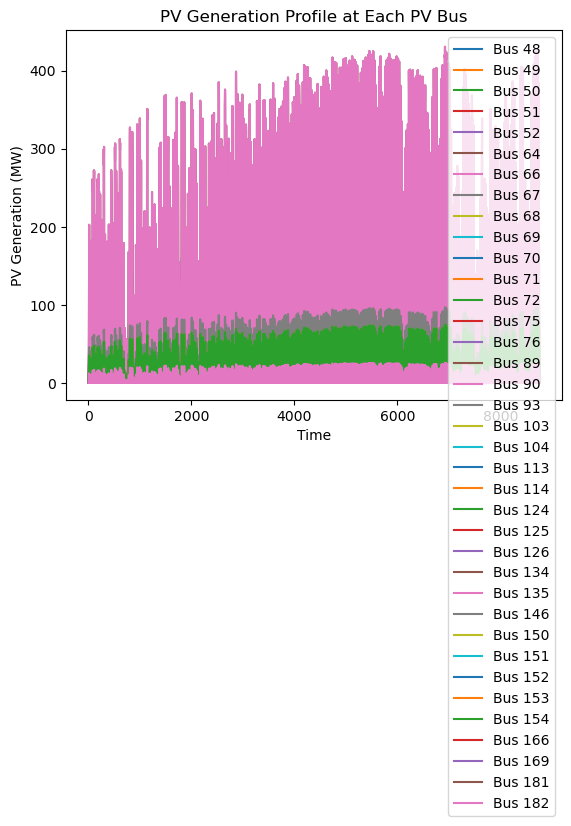

In [16]:
# Assuming the Excel file has columns corresponding to the first 5 buses for PV generation profiles
# Define the output directory and updated file path for res_sgen
output_dir = "C:/Apps-SU/300Buses/res_sgen/" #LAB PC

result_file_path = os.path.join(output_dir, "p_mw.xlsx")
try:
    # Load the data from p_mw.xlsx for plotting
    pv_generation_data = pd.read_excel(result_file_path, usecols="B:AL")  
    plt.figure()
    plt.title('PV Generation Profile at Each PV Bus')

    # Plot each bus's generation profile from the loaded data
    for i, bus in enumerate(pv_buses):
        plt.plot(pv_generation_data.iloc[:, i], label=f'Bus {bus}')  # Use column for bus

    plt.xlabel('Time')
    plt.ylabel('PV Generation (MW)')
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"File not found: {result_file_path}")

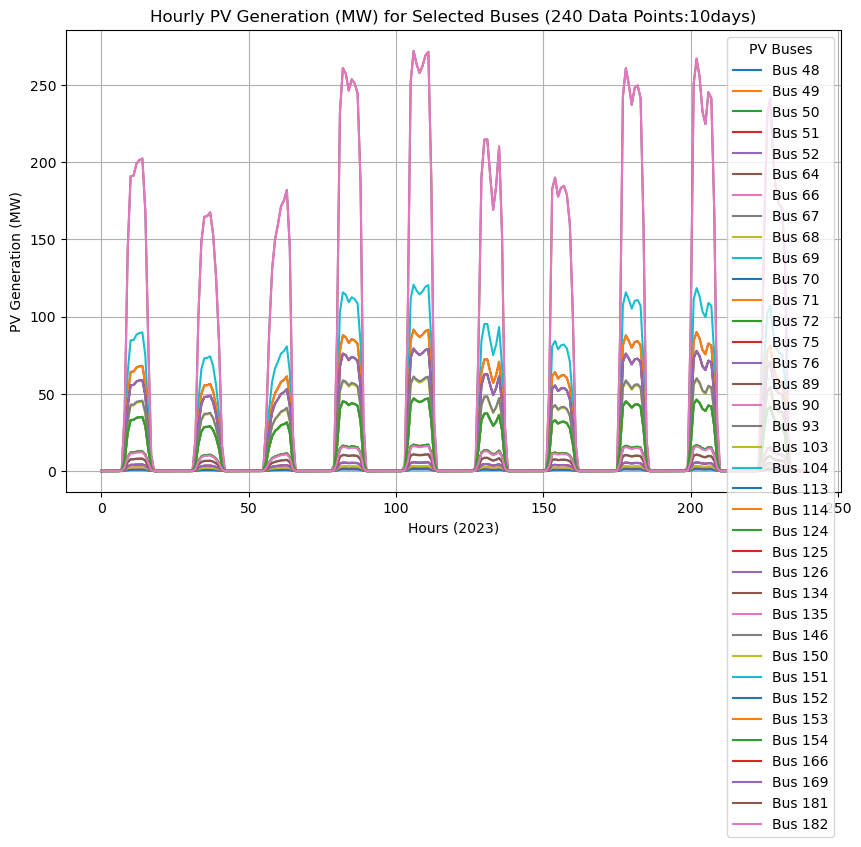

In [17]:
# Plotting the first 240 data points for each bus
plt.figure(figsize=(10, 6))
for i, bus in enumerate(pv_buses):
    plt.plot(pv_generation_data.index[:240], pv_generation_data.iloc[:240, i], label=f'Bus {bus}')

# Setting labels and title
plt.xlabel('Hours (2023)')
plt.ylabel('PV Generation (MW)')
plt.title('Hourly PV Generation (MW) for Selected Buses (240 Data Points:10days)')
plt.legend(title="PV Buses")
plt.grid(True)
plt.show()

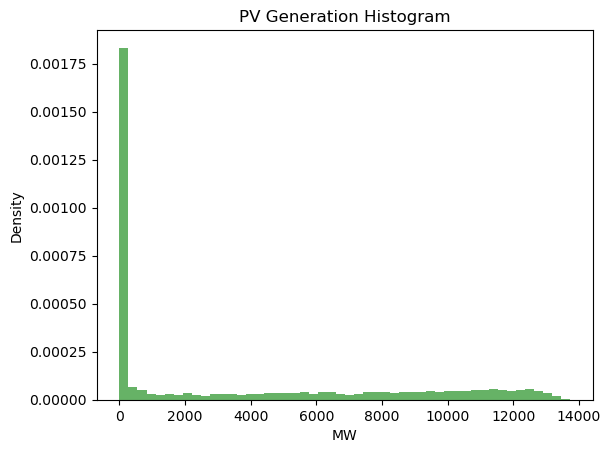

In [18]:
# Plot histogram of the data to visually inspect distribution
plt.hist(pv_generation, bins=50, density=True, alpha=0.6, color='g')
plt.title("PV Generation Histogram")
plt.xlabel("MW")
plt.ylabel("Density")
plt.show()

## Perform optimal power flow (OPF) analysis

In [ ]:
pp.runopp(net)
print("OPF Results:")
print(net.res_bus)
print(net.res_line)

 ## Monte Carlo Analysis for system reliability

In [20]:
# Calculate mean and std for each PV bus from 2023 data
pv_bus_means =  pv_generation_data.mean()
pv_bus_stds =  pv_generation_data.std()

# Print the mean and standard deviation for each PV bus
print("Mean Generation for each PV bus:\n", pv_bus_means )
print("\nStandard Deviation for each PV bus:\n", pv_bus_stds)

Mean Generation for each PV bus:
 11      1.156563
12      1.156563
13      1.156563
14      1.156563
15      2.315680
16     38.398924
17      1.199966
18      7.128311
19      7.128311
20      7.128311
21      7.128311
22      7.128311
23      7.128311
24      1.021248
25      0.612749
26      0.816998
27      1.276560
28      4.595616
29     25.275888
30     50.551775
31      0.434030
32     38.296800
33     33.203325
34     33.203325
35     33.203325
36    113.971276
37    113.971276
38     25.658856
39      1.378685
40     19.715192
41     19.715192
42     19.715192
43     19.715192
44      2.399933
45      2.399933
46      4.467960
47      6.791299
dtype: float64

Standard Deviation for each PV bus:
 11      1.450852
12      1.450852
13      1.450852
14      1.450852
15      2.904907
16     48.169568
17      1.505299
18      8.942117
19      8.942117
20      8.942117
21      8.942117
22      8.942117
23      8.942117
24      1.281106
25      0.768663
26      1.024884
27      1.60

In [50]:
# ReLoad the 200-Bus power system
net = pn.case_illinois200()
# Identify the PV buses in the IEEE 30-bus system
pv_buses = [48, 49, 50, 51, 52,64,66,67,68,69,70,71,72,75,76,89,90,93,103,104,113,114,124,125,126,134,135,146,150,151,152,153,154,166,169,181,182]
# Create Static Generators (sgen) for the PV buses
for bus, installed_capacity in zip(pv_buses, installed_capacities):
    pp.create_sgen(net, bus, p_mw=0, max_p_mw=installed_capacity, name=f"PV_bus_{bus}")
    # Verify static generator table
print(net.sgen)

          name  bus  p_mw  q_mvar  sn_mva  scaling  in_service type  \
0         None   77   0.0     0.0     NaN      1.0       False        
1         None   78   0.0     0.0     NaN      1.0       False        
2         None   91   0.0     0.0     NaN      1.0       False        
3         None  160   0.0     0.0     NaN      1.0       False        
4         None  163   0.0     0.0     NaN      1.0       False        
5         None  164   0.0     0.0     NaN      1.0       False        
6         None  165   0.0     0.0     NaN      1.0       False        
7         None  167   0.0     0.0     NaN      1.0       False        
8         None  168   0.0     0.0     NaN      1.0       False        
9         None  195   0.0     0.0     NaN      1.0       False        
10        None  196   0.0     0.0     NaN      1.0       False        
11   PV_bus_48   48   0.0     0.0     NaN      1.0        True  wye   
12   PV_bus_49   49   0.0     0.0     NaN      1.0        True  wye   
13   P

In [51]:
n_scenarios = 100  # Number of scenarios
n_runs_per_scenario = 200  # Monte Carlo runs per scenario
scenario_results = []
# Acceptable variation (Assume variation with the original mean and std)
mean_variation = 1.0
std_variation = 1.0

In [52]:
# Iterate over scenarios
for scenario in range(n_scenarios):
    scenario_lolps = []  # Store LOLP for each run in this scenario

In [53]:
# Generate scenarios
for scenario in range(n_scenarios):
    # Adjust mean and std for this scenario
    print(f"Running Scenario {scenario + 1}/{n_scenarios}")
    lolp_count = 0  # To count the number of load losses
    scenario_means = [mean * (1 + np.random.uniform(-mean_variation, mean_variation)) for mean in pv_bus_means]
    scenario_stds = [std * (1 + np.random.uniform(-std_variation, std_variation)) for std in pv_bus_stds]
    
    scenario_lolps = []  # Store LOLP for each run in this scenario
    total_solar_generation = []
    total_reactive_power = []
    voltage_deviations = []
    for run in range(n_runs_per_scenario):
        # Sample PV outputs from normal distribution
        pv_outputs = [max(0, np.random.normal(mean, std)) for mean, std in zip(scenario_means, scenario_stds)]
        
        # Update PV generation in the network
        for i, bus in enumerate(pv_buses):
            net.sgen.loc[net.sgen['bus'] == bus, 'p_mw'] = pv_outputs[i]
        
        try:
            # Run power flow
            pp.runpp(net)
            
            # Calculate metrics
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_solar_generation.append(net.res_sgen['p_mw'].sum())
            total_reactive_power.append(net.res_bus['q_mvar'].sum())
            voltage_deviation = np.mean(abs(net.res_bus['vm_pu'] - 1.0))
            voltage_deviations.append(voltage_deviation)
            
            # Calculate voltage deviation from 1.0 p.u.
            voltage_dev = abs(net.res_bus['vm_pu'] - 1).mean()
            voltage_deviations.append(voltage_dev)
            
            # Calculate LOLP
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_load = net.load['p_mw'].sum()
            lolp = 1 if total_generation < total_load else 0  # Load loss if generation < load
            scenario_lolps.append(lolp)
        except pp.LoadflowNotConverged:
            print(f"Power flow did not converge for scenario {scenario}, run {run}.")
            continue
    
    # Calculate average LOLP for this scenario
    avg_lolp = np.mean(scenario_lolps) if scenario_lolps else None
    print(f"Scenario {scenario + 1}: Average LOLP = {avg_lolp}")
    avg_solar_generation = np.mean(total_solar_generation)
    avg_reactive_power = np.mean(total_reactive_power)
    avg_voltage_deviation = np.mean(voltage_deviations)
    
    # Calculate LOLP for this scenario
    lolp = lolp_count / n_runs_per_scenario
    scenario_results.append({
        'Scenario': scenario + 1,
    'PV11 Mean Output': scenario_means[0],
    'PV11 Std Output': scenario_stds[0],
    'PV12 Mean Output': scenario_means[1],
    'PV12 Std Output': scenario_stds[1],
    'PV13 Mean Output': scenario_means[2],
    'PV13 Std Output': scenario_stds[2],
    'PV14 Mean Output': scenario_means[3],
    'PV14 Std Output': scenario_stds[3],
    'PV15 Mean Output': scenario_means[4],
    'PV15 Std Output': scenario_stds[4],
    'PV16 Mean Output': scenario_means[5],
    'PV16 Std Output': scenario_stds[5],
    'PV17 Mean Output': scenario_means[6],
    'PV17 Std Output': scenario_stds[6],
    'PV18 Mean Output': scenario_means[7],
    'PV18 Std Output': scenario_stds[7],
    'PV19 Mean Output': scenario_means[8],
    'PV19 Std Output': scenario_stds[8],
    'PV20 Mean Output': scenario_means[9],
    'PV20 Std Output': scenario_stds[9],
    'PV21 Mean Output': scenario_means[10],
    'PV21 Std Output': scenario_stds[10],
    'PV22 Mean Output': scenario_means[11],
    'PV22 Std Output': scenario_stds[11],
    'PV23 Mean Output': scenario_means[12],
    'PV23 Std Output': scenario_stds[12],
    'PV24 Mean Output': scenario_means[13],
    'PV24 Std Output': scenario_stds[13],
    'PV25 Mean Output': scenario_means[14],
    'PV25 Std Output': scenario_stds[14],
    'PV26 Mean Output': scenario_means[15],
    'PV26 Std Output': scenario_stds[15],
    'PV27 Mean Output': scenario_means[16],
    'PV27 Std Output': scenario_stds[16],
    'PV28 Mean Output': scenario_means[17],
    'PV28 Std Output': scenario_stds[17],
    'PV29 Mean Output': scenario_means[18],
    'PV29 Std Output': scenario_stds[18],
    'PV30 Mean Output': scenario_means[19],
    'PV30 Std Output': scenario_stds[19],
    'PV31 Mean Output': scenario_means[20],
    'PV31 Std Output': scenario_stds[20],
    'PV32 Mean Output': scenario_means[21],
    'PV32 Std Output': scenario_stds[21],
    'PV33 Mean Output': scenario_means[22],
    'PV33 Std Output': scenario_stds[22],
    'PV34 Mean Output': scenario_means[23],
    'PV34 Std Output': scenario_stds[23],
    'PV35 Mean Output': scenario_means[24],
    'PV35 Std Output': scenario_stds[24],
    'PV36 Mean Output': scenario_means[25],
    'PV36 Std Output': scenario_stds[25],
    'PV37 Mean Output': scenario_means[26],
    'PV37 Std Output': scenario_stds[26],
    'PV38 Mean Output': scenario_means[27],
    'PV38 Std Output': scenario_stds[27],
    'PV39 Mean Output': scenario_means[28],
    'PV39 Std Output': scenario_stds[28],
    'PV40 Mean Output': scenario_means[29],
    'PV40 Std Output': scenario_stds[29],
    'PV41 Mean Output': scenario_means[30],
    'PV41 Std Output': scenario_stds[30],
    'PV42 Mean Output': scenario_means[31],
    'PV42 Std Output': scenario_stds[31],
    'PV43 Mean Output': scenario_means[32],
    'PV43 Std Output': scenario_stds[32],
    'PV44 Mean Output': scenario_means[33],
    'PV44 Std Output': scenario_stds[33],
    'PV45 Mean Output': scenario_means[34],
    'PV45 Std Output': scenario_stds[34],
    'PV46 Mean Output': scenario_means[35],
    'PV46 Std Output': scenario_stds[35],
    'PV47 Mean Output': scenario_means[36],
    'PV47 Std Output': scenario_stds[36],
        'Total Solar Generation': avg_solar_generation,
        'Total Reactive Power': avg_reactive_power,
        'Voltage Deviation': avg_voltage_deviation,
        'LOLP': avg_lolp
    })

# Save results to a DataFrame
df_scenario_results = pd.DataFrame(scenario_results)
df_scenario_results.to_excel("100_scenarios_200buses_results.xlsx", index=False)
print("Scenario results saved to '100_scenarios_200buses_results.xlsx'.")

Running Scenario 1/100
Scenario 1: Average LOLP = 0.26
Running Scenario 2/100
Scenario 2: Average LOLP = 0.09
Running Scenario 3/100
Scenario 3: Average LOLP = 0.005
Running Scenario 4/100
Scenario 4: Average LOLP = 0.11
Running Scenario 5/100
Scenario 5: Average LOLP = 0.125
Running Scenario 6/100
Scenario 6: Average LOLP = 0.175
Running Scenario 7/100
Scenario 7: Average LOLP = 0.195
Running Scenario 8/100
Scenario 8: Average LOLP = 0.36
Running Scenario 9/100
Scenario 9: Average LOLP = 0.375
Running Scenario 10/100
Scenario 10: Average LOLP = 0.16
Running Scenario 11/100
Scenario 11: Average LOLP = 0.11
Running Scenario 12/100
Scenario 12: Average LOLP = 0.22
Running Scenario 13/100
Scenario 13: Average LOLP = 0.02
Running Scenario 14/100
Scenario 14: Average LOLP = 0.155
Running Scenario 15/100
Scenario 15: Average LOLP = 0.395
Running Scenario 16/100
Scenario 16: Average LOLP = 0.17
Running Scenario 17/100
Scenario 17: Average LOLP = 0.06
Running Scenario 18/100
Scenario 18: Avera

In [54]:
import dowhy
from dowhy import CausalModel

In [55]:
data = pd.read_excel('100_scenarios_200buses_results.xlsx')
# View data structure
print(data.head())

   Scenario  PV11 Mean Output  PV11 Std Output  PV12 Mean Output  \
0         1          0.446194         2.295647          0.368942   
1         2          0.875144         0.339935          1.698105   
2         3          0.682397         0.132080          0.736772   
3         4          0.064410         2.784867          1.642536   
4         5          1.660896         2.846072          0.328173   

   PV12 Std Output  PV13 Mean Output  PV13 Std Output  PV14 Mean Output  \
0         2.328361          2.265933         2.700040          0.059566   
1         2.698086          1.140958         2.384997          1.697680   
2         0.250473          2.103793         2.727512          1.338685   
3         1.306318          1.054698         2.742257          2.005444   
4         0.282010          0.784569         2.121339          0.588667   

   PV14 Std Output  PV15 Mean Output  PV15 Std Output  PV16 Mean Output  \
0         1.433744          2.042556         1.693428         29.

Analyzing causal effect of PV11 Mean Output on LOLP:


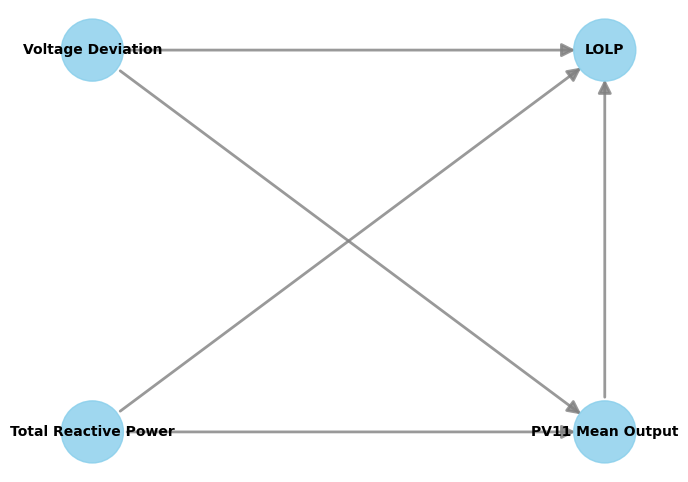

Causal Effect of PV11 Mean Output on LOLP: -0.00020602827634075283


Analyzing causal effect of PV12 Mean Output on LOLP:


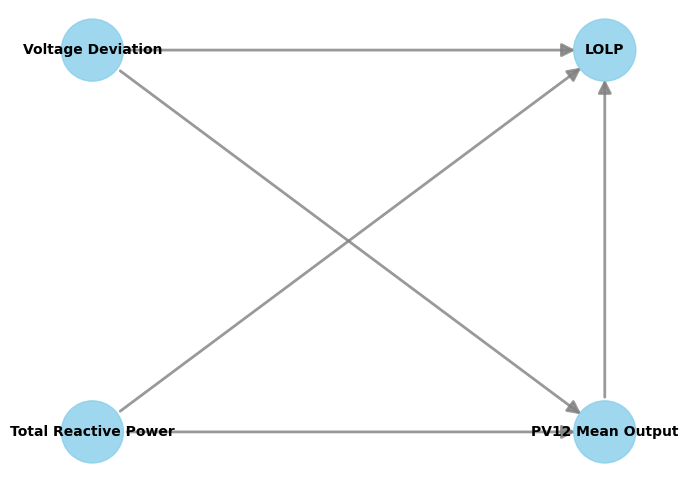

Causal Effect of PV12 Mean Output on LOLP: -0.0005028273517968529


Analyzing causal effect of PV13 Mean Output on LOLP:


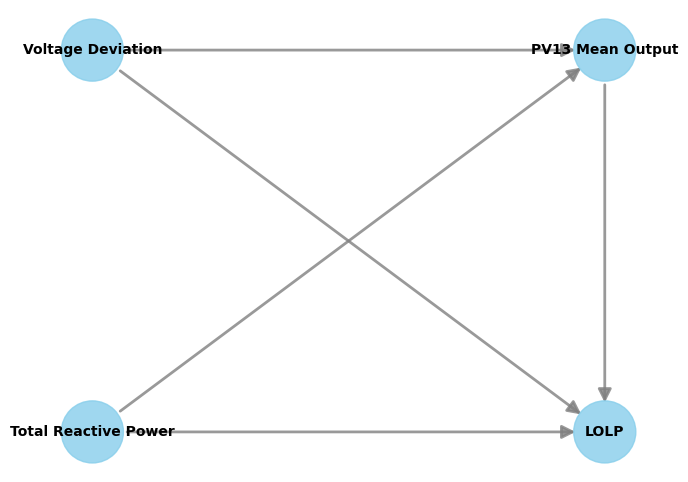

Causal Effect of PV13 Mean Output on LOLP: -0.012450808521288909


Analyzing causal effect of PV14 Mean Output on LOLP:


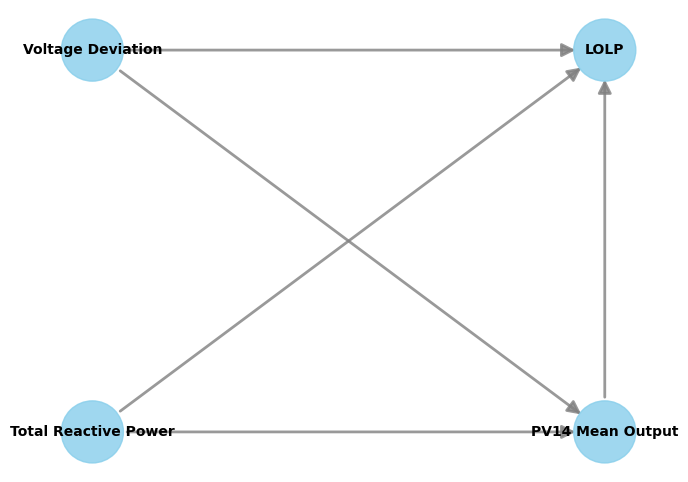

Causal Effect of PV14 Mean Output on LOLP: -0.0068831601478276105


Analyzing causal effect of PV15 Mean Output on LOLP:


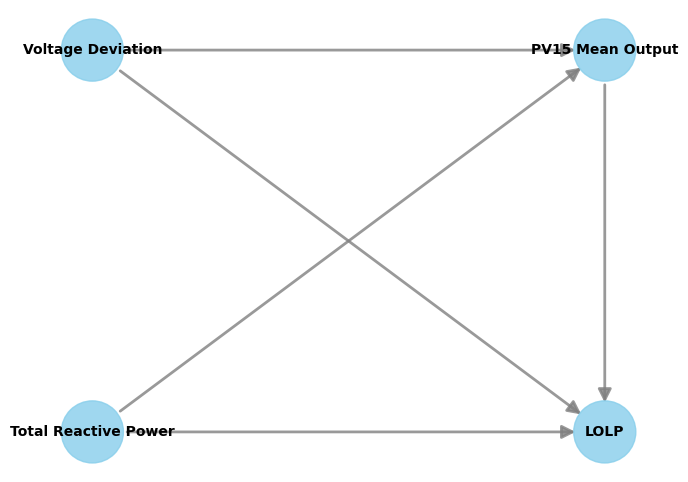

Causal Effect of PV15 Mean Output on LOLP: -0.003975837322250708


Analyzing causal effect of PV16 Mean Output on LOLP:


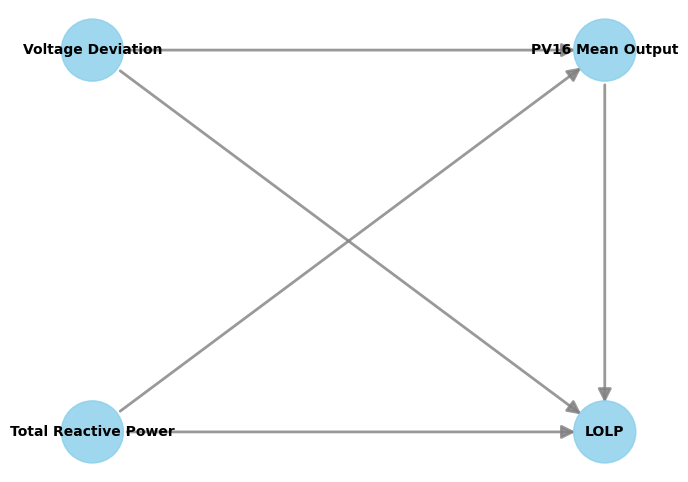

Causal Effect of PV16 Mean Output on LOLP: 0.00021571233565698122


Analyzing causal effect of PV17 Mean Output on LOLP:


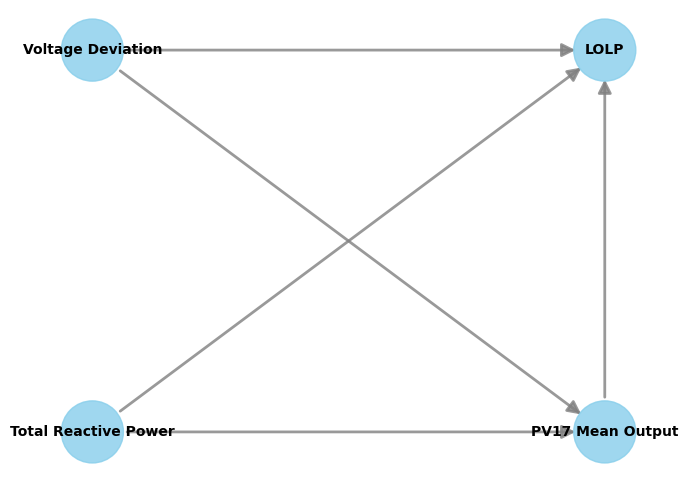

Causal Effect of PV17 Mean Output on LOLP: 0.010215161102830272


Analyzing causal effect of PV18 Mean Output on LOLP:


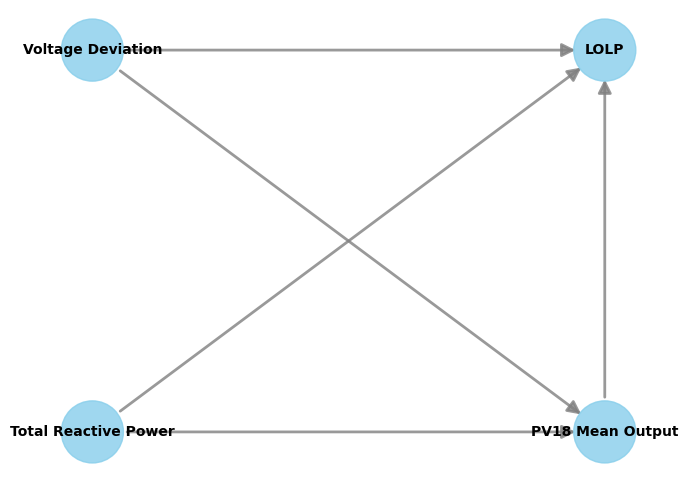

Causal Effect of PV18 Mean Output on LOLP: -0.0004755819312753373


Analyzing causal effect of PV19 Mean Output on LOLP:


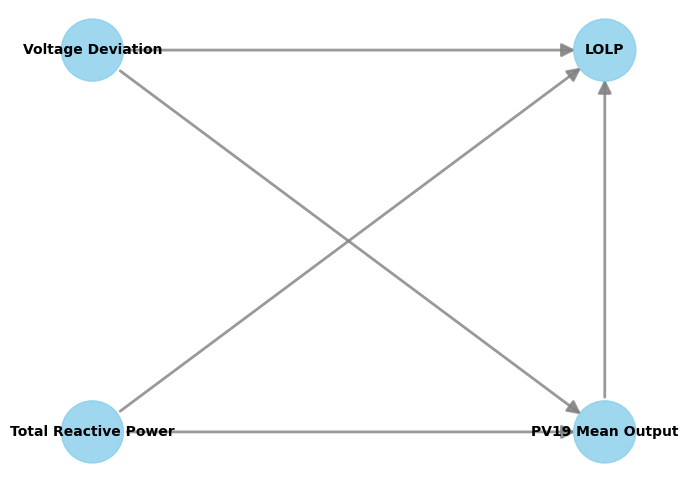

Causal Effect of PV19 Mean Output on LOLP: 0.0004067748761116263


Analyzing causal effect of PV20 Mean Output on LOLP:


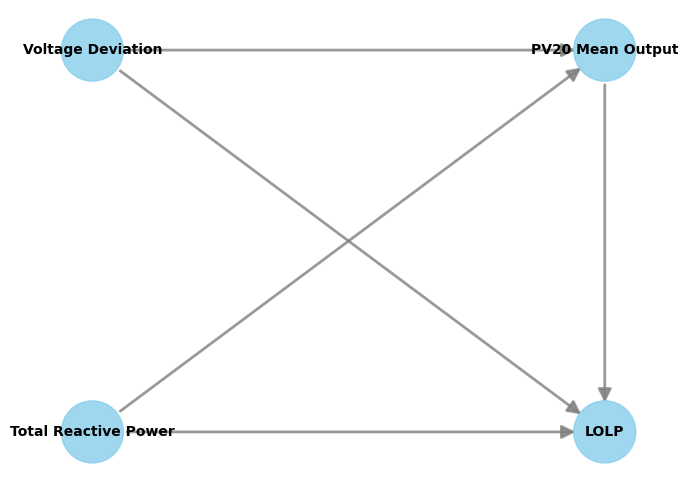

Causal Effect of PV20 Mean Output on LOLP: 0.0024982150792043634


Analyzing causal effect of PV21 Mean Output on LOLP:


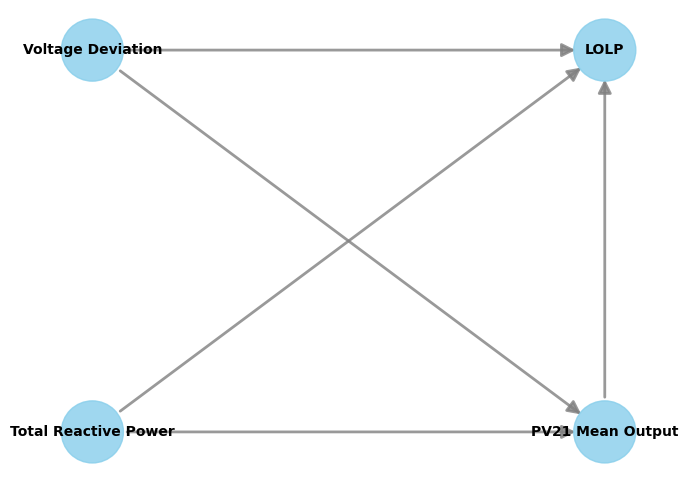

Causal Effect of PV21 Mean Output on LOLP: 0.0006932343093986049


Analyzing causal effect of PV22 Mean Output on LOLP:


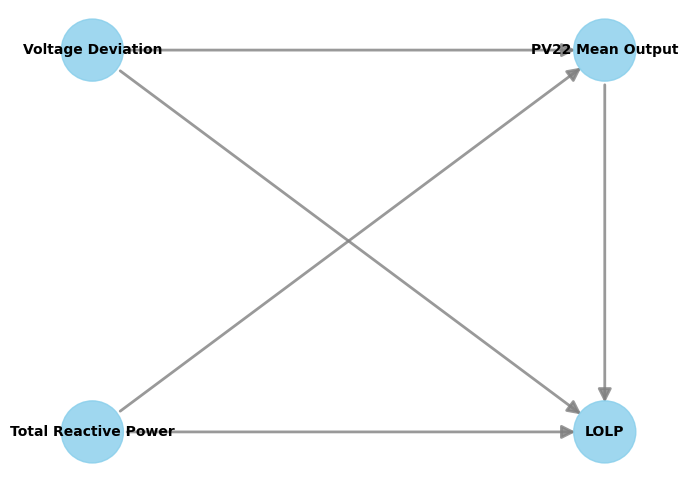

Causal Effect of PV22 Mean Output on LOLP: -0.0023836827919789805


Analyzing causal effect of PV23 Mean Output on LOLP:


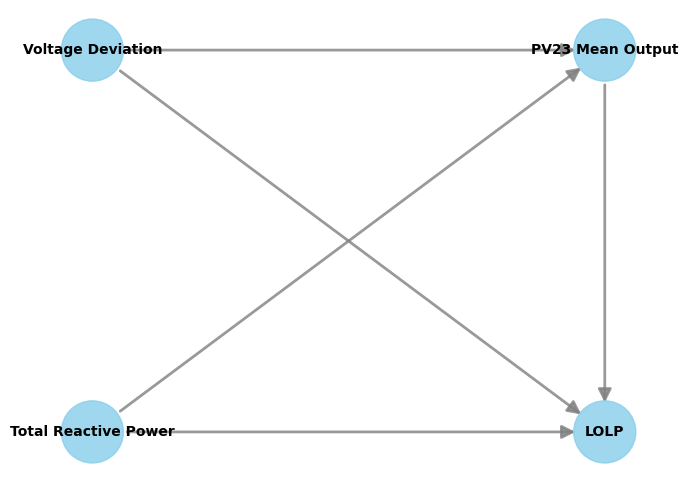

Causal Effect of PV23 Mean Output on LOLP: -0.002295811098468964


Analyzing causal effect of PV24 Mean Output on LOLP:


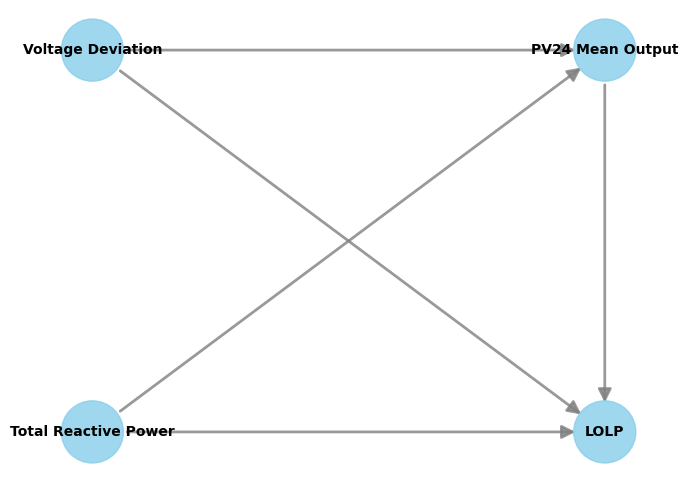

Causal Effect of PV24 Mean Output on LOLP: -0.010564602915613008


Analyzing causal effect of PV25 Mean Output on LOLP:


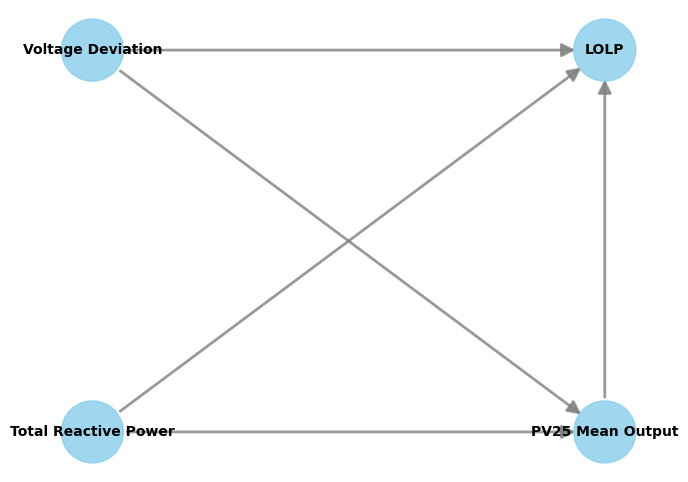

Causal Effect of PV25 Mean Output on LOLP: -0.015572604109542504


Analyzing causal effect of PV26 Mean Output on LOLP:


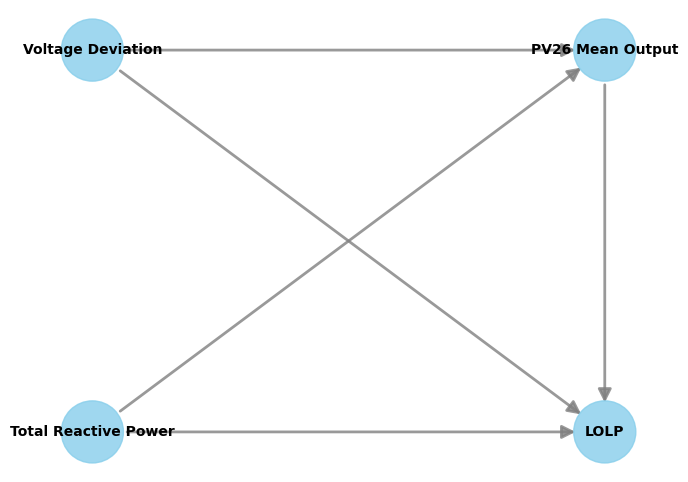

Causal Effect of PV26 Mean Output on LOLP: -0.009740762955865429


Analyzing causal effect of PV27 Mean Output on LOLP:


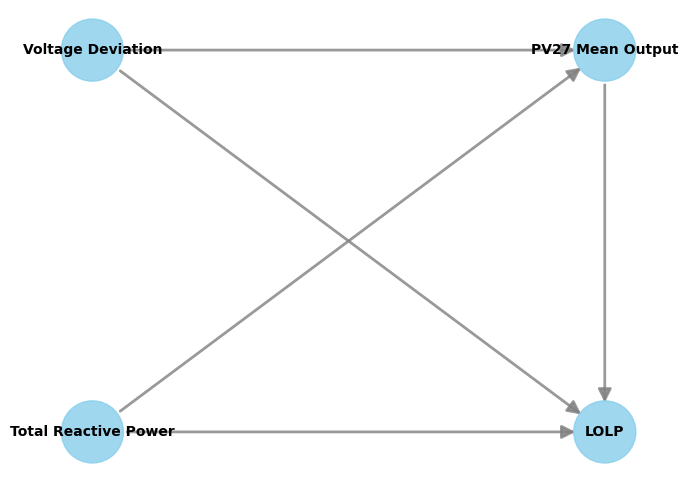

Causal Effect of PV27 Mean Output on LOLP: 0.00450024726138043


Analyzing causal effect of PV28 Mean Output on LOLP:


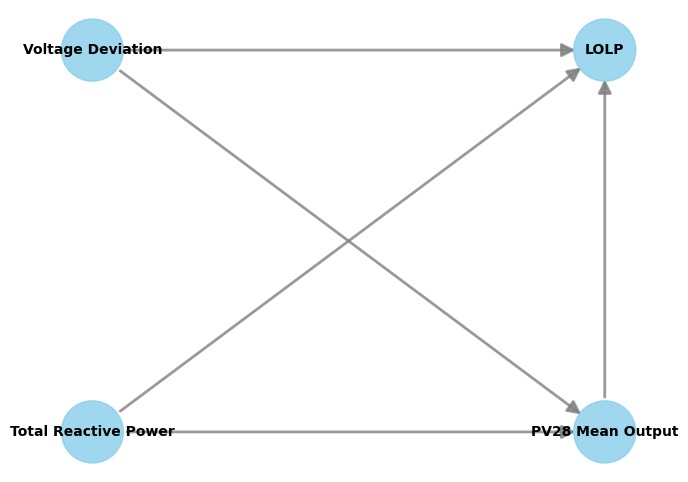

Causal Effect of PV28 Mean Output on LOLP: -0.003227610727284169


Analyzing causal effect of PV29 Mean Output on LOLP:


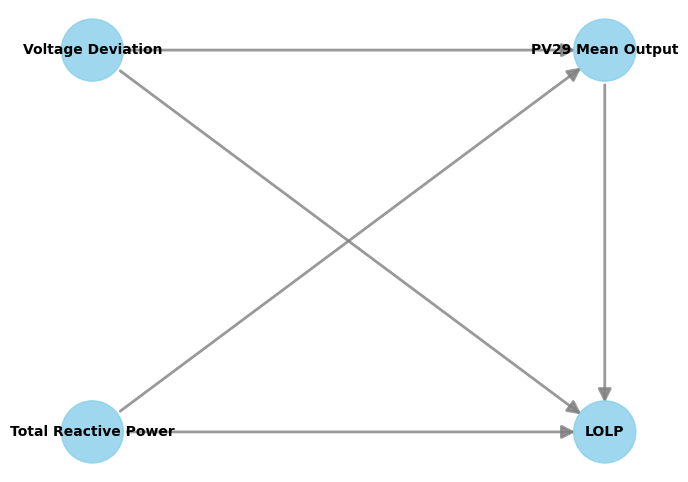

Causal Effect of PV29 Mean Output on LOLP: -0.0005680476402245005


Analyzing causal effect of PV30 Mean Output on LOLP:


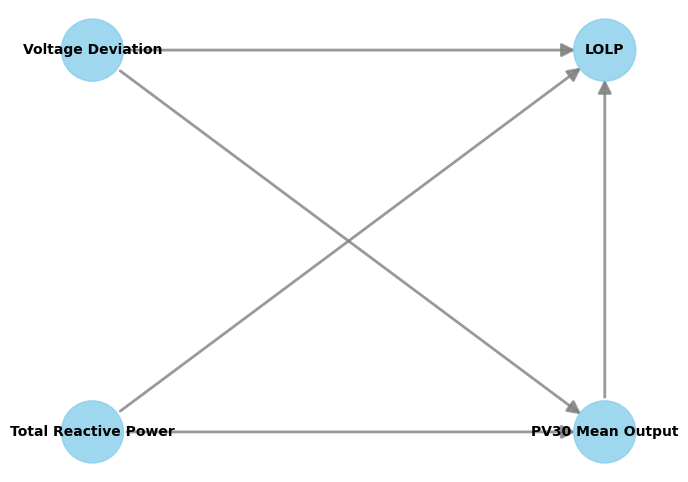

Causal Effect of PV30 Mean Output on LOLP: 0.0001368012166049759


Analyzing causal effect of PV31 Mean Output on LOLP:


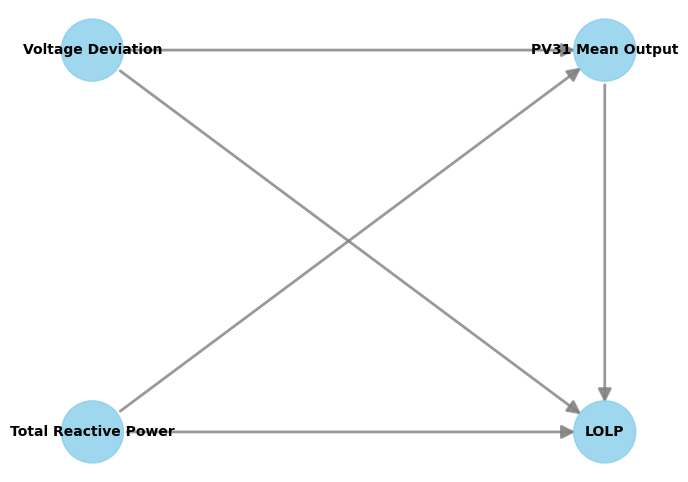

Causal Effect of PV31 Mean Output on LOLP: 0.00196803215035099


Analyzing causal effect of PV32 Mean Output on LOLP:


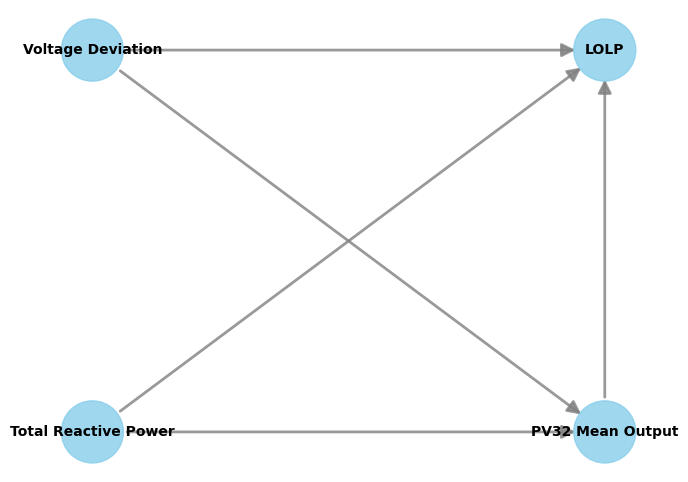

Causal Effect of PV32 Mean Output on LOLP: 0.0002773359168242173


Analyzing causal effect of PV33 Mean Output on LOLP:


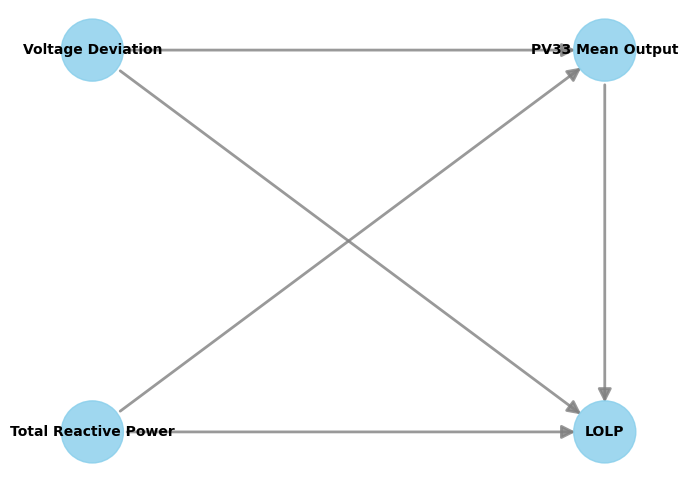

Causal Effect of PV33 Mean Output on LOLP: -0.0004630928610232232


Analyzing causal effect of PV34 Mean Output on LOLP:


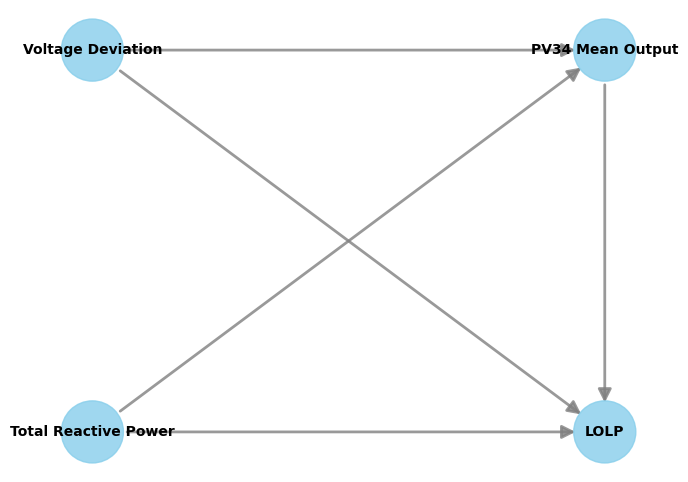

Causal Effect of PV34 Mean Output on LOLP: -0.00032088598493687503


Analyzing causal effect of PV35 Mean Output on LOLP:


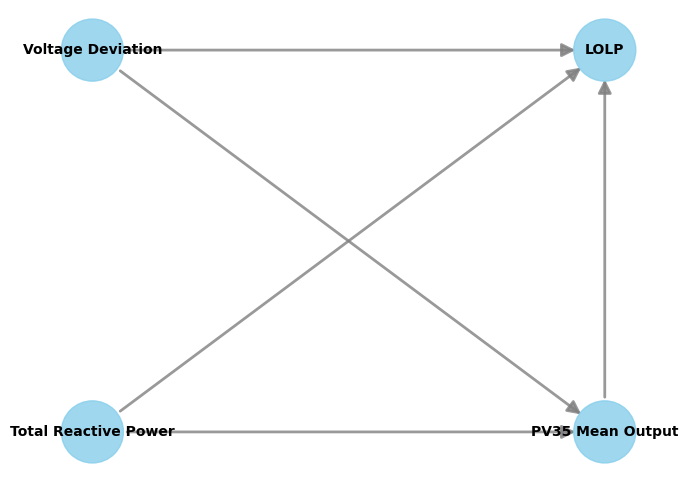

Causal Effect of PV35 Mean Output on LOLP: -0.0003974601899740804


Analyzing causal effect of PV36 Mean Output on LOLP:


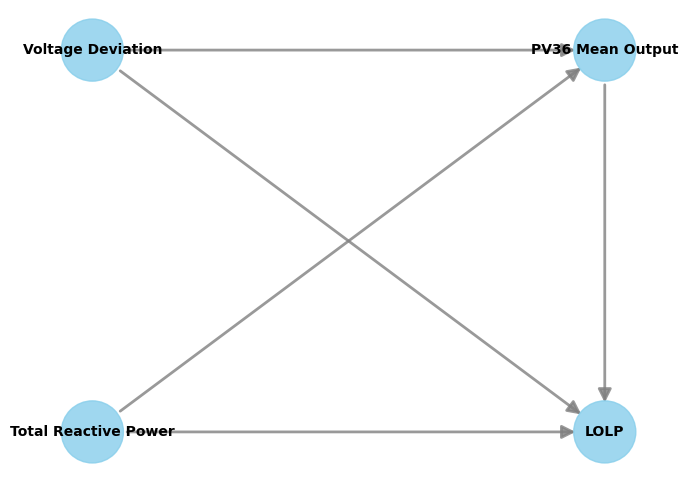

Causal Effect of PV36 Mean Output on LOLP: -5.1475720845406414e-05


Analyzing causal effect of PV37 Mean Output on LOLP:


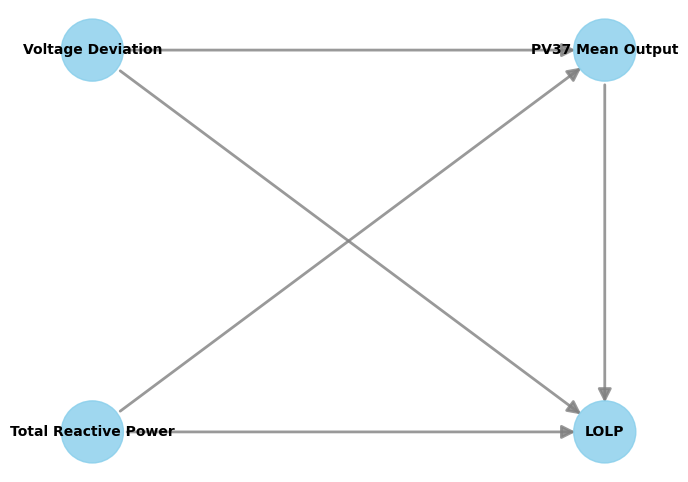

Causal Effect of PV37 Mean Output on LOLP: -0.0001954442833072001


Analyzing causal effect of PV38 Mean Output on LOLP:


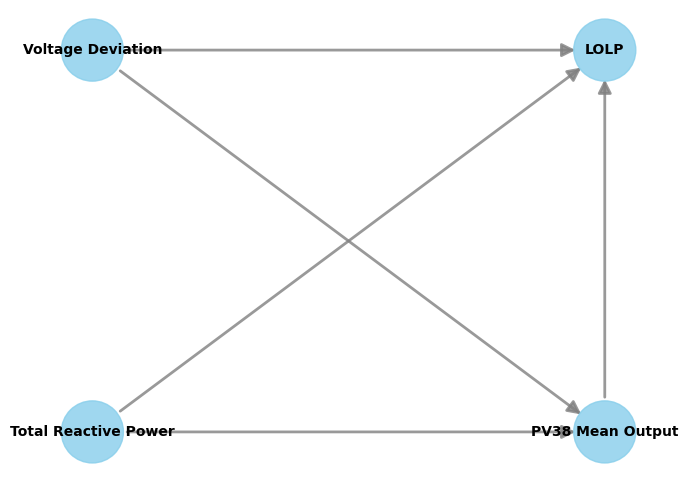

Causal Effect of PV38 Mean Output on LOLP: -0.0006554821014557455


Analyzing causal effect of PV39 Mean Output on LOLP:


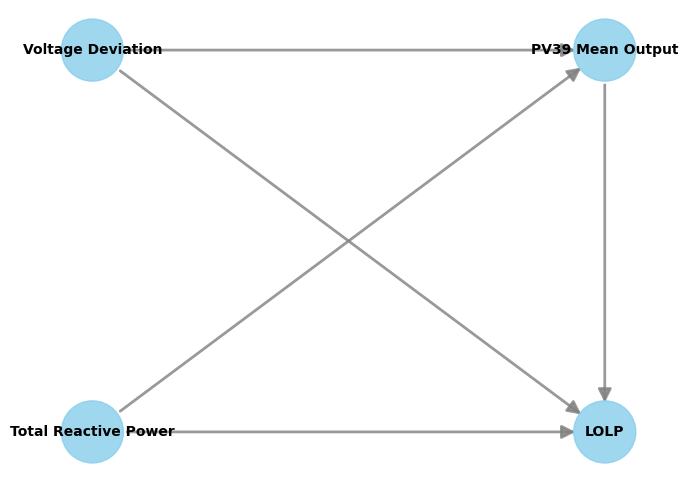

Causal Effect of PV39 Mean Output on LOLP: -0.00045215027206335634


Analyzing causal effect of PV40 Mean Output on LOLP:


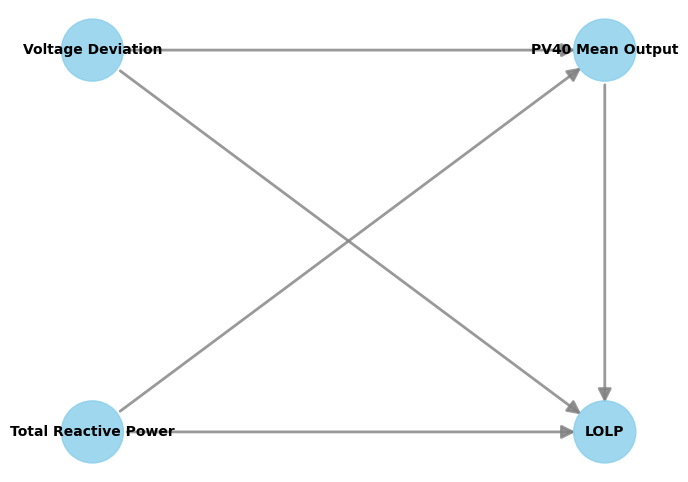

Causal Effect of PV40 Mean Output on LOLP: -0.0006324198381713053


Analyzing causal effect of PV41 Mean Output on LOLP:


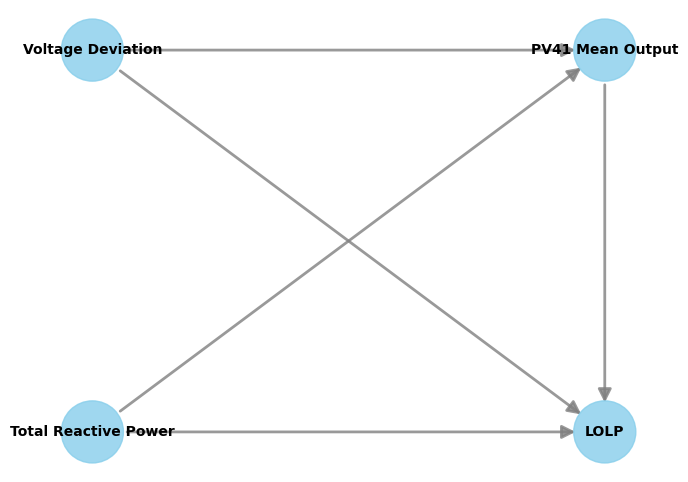

Causal Effect of PV41 Mean Output on LOLP: 8.888267344667189e-05


Analyzing causal effect of PV42 Mean Output on LOLP:


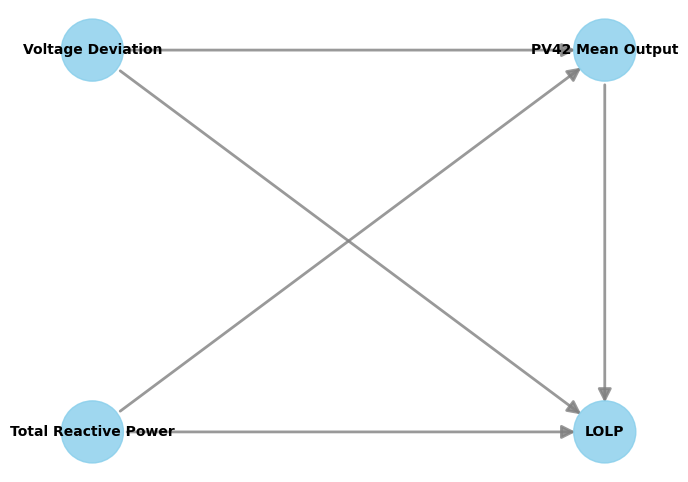

Causal Effect of PV42 Mean Output on LOLP: -8.370146772440634e-05


Analyzing causal effect of PV43 Mean Output on LOLP:


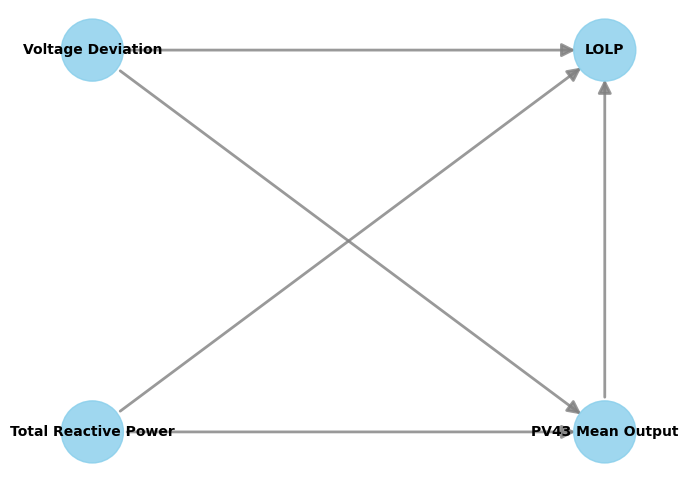

Causal Effect of PV43 Mean Output on LOLP: 0.00040106046410315344


Analyzing causal effect of PV44 Mean Output on LOLP:


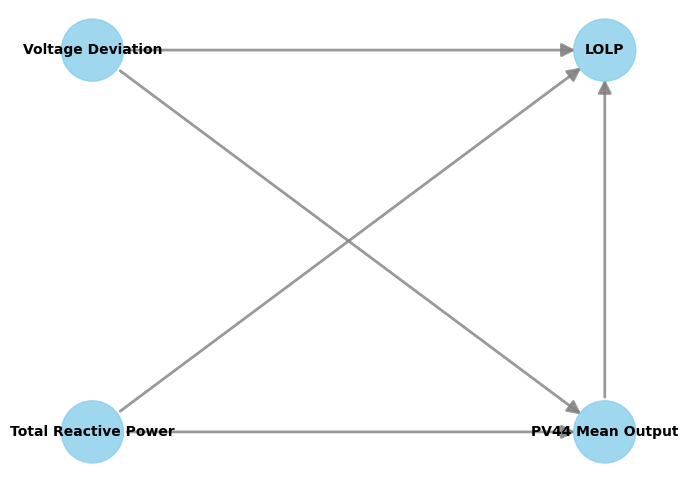

Causal Effect of PV44 Mean Output on LOLP: -0.009494904902145801


Analyzing causal effect of PV45 Mean Output on LOLP:


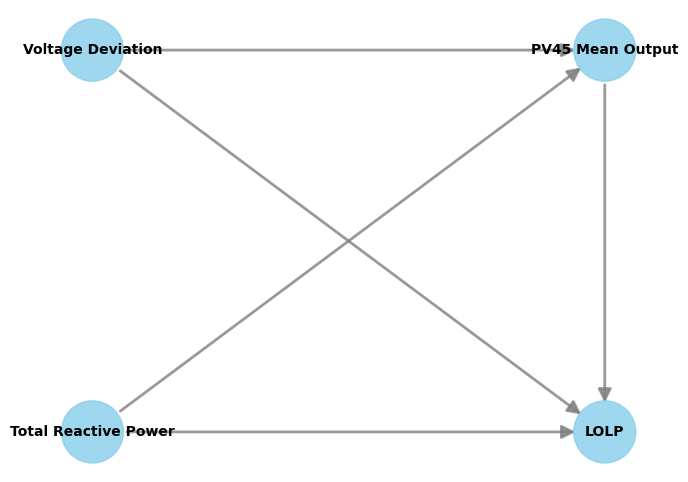

Causal Effect of PV45 Mean Output on LOLP: -0.011700337532910776


Analyzing causal effect of PV46 Mean Output on LOLP:


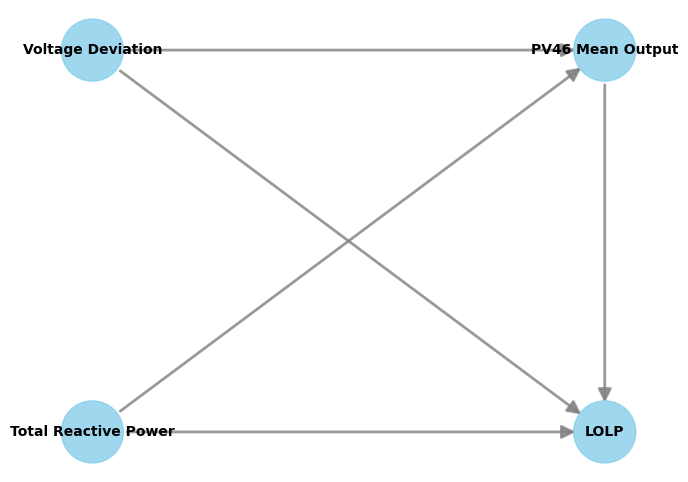

Causal Effect of PV46 Mean Output on LOLP: -0.0025040747781747974


Analyzing causal effect of PV47 Mean Output on LOLP:


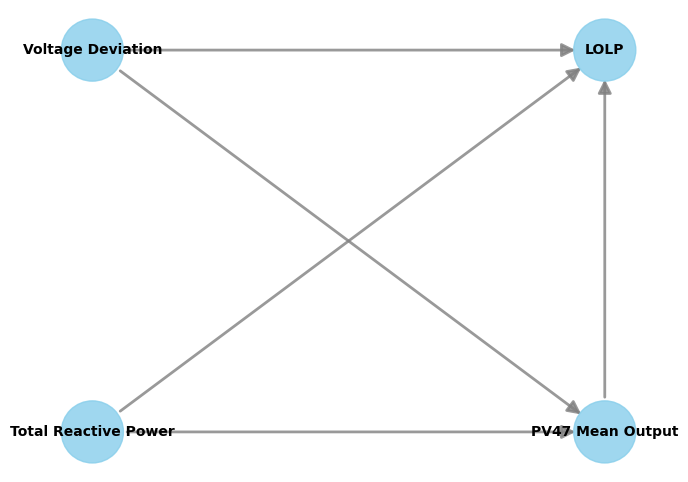

Causal Effect of PV47 Mean Output on LOLP: 0.0007045004187204995


Analyzing causal effect of Total Solar Generation on LOLP:


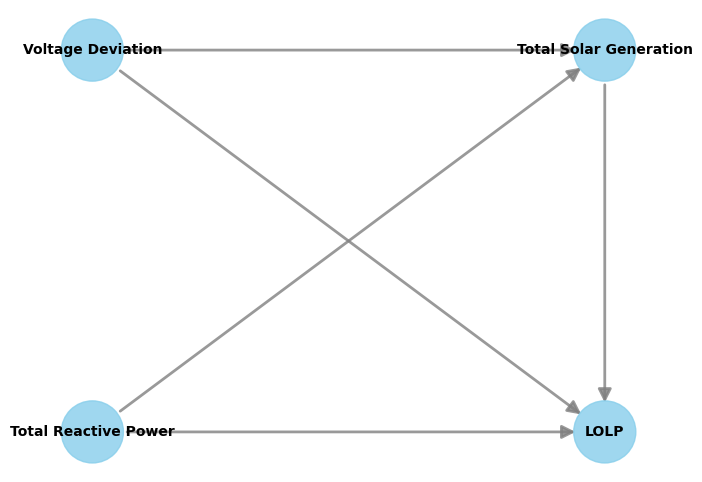

Causal Effect of Total Solar Generation on LOLP: -0.001526307848676689




In [56]:
# Iterate over each PV bus output as the treatment variable
#pv_buses = ['PV1 Mean Output', 'PV2 Mean Output', 'PV3 Mean Output', 'PV4 Mean Output', 'PV5 Mean Output','Total Solar Generation']
pv_buses = [f'PV{i} Mean Output' for i in range(11, 48)] + ['Total Solar Generation']

for pv_bus in pv_buses:
    print(f"Analyzing causal effect of {pv_bus} on LOLP:")
    # Define the causal model
    model = CausalModel(
    data=data,
    treatment=pv_bus,  # Treatments
    outcome='LOLP',  # Reliability indicator
    common_causes=['Voltage Deviation', 'Total Reactive Power']  # Confounders
    )# Visualize the DAG
    model.view_model()

# Identify and estimate the causal effect
    identified_estimand = model.identify_effect()
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )
    
    print(f"Causal Effect of {pv_bus} on LOLP: {causal_estimate.value}")
    print("\n")